In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vehicle-claim-fraud-detection/fraud_oracle.csv


<div style="background-color:#f4f6f9; padding: 20px; border-radius: 10px; border: 2px solid #b0b7bf; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);">
  <h1 style="text-align:center; color:#2c3e50; font-family: 'Arial', sans-serif; font-size: 28px; font-weight: bold; margin-bottom: 10px;">
    📖Complete Guidebook📖
  </h1>
  <h2 style="text-align:center; color:#2980b9; font-family: 'Arial', sans-serif; font-size: 24px; font-weight: bold; margin-top: 0;">
    Vehicle Claim Fraud Detection: From Data Preprocessing to Modeling
  </h2>
</div>

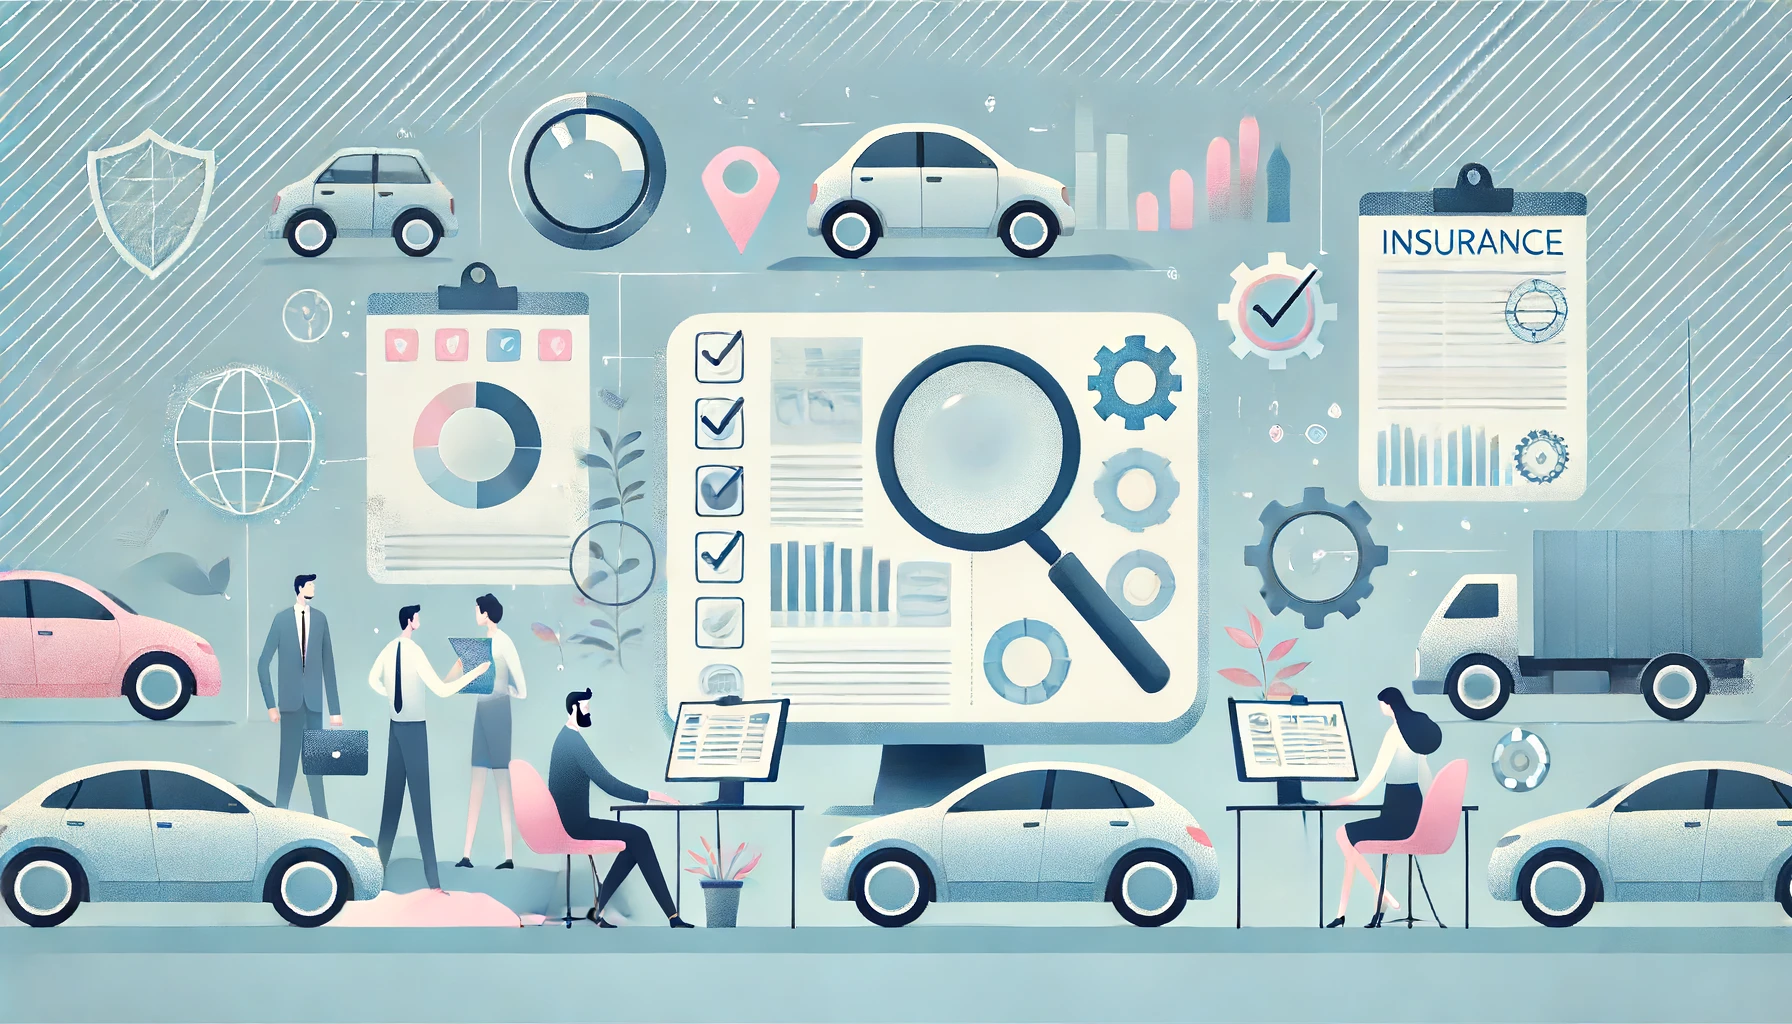

# ✨**Introduction**✨

The purpose of this document is to provide a detailed explanation of the process of building a classification model from A to Z, specifically for detecting fraud in vehicle insurance claims. This project aims to offer a comprehensive walkthrough, ensuring that readers can understand and replicate the steps involved in creating an effective classification model.

In this project, we have employed several **advanced techniques** to enhance the model's performance and ensure robust results. These techniques include:

* **SMOTE Oversampling**: To address the issue of imbalanced data, we used Synthetic Minority Over-sampling Technique (SMOTE). This method generates synthetic samples for the minority class, helping the model to learn better and reduce bias.<br/>
<br/>
* **RFECV (Recursive Feature Elimination with Cross-Validation)**: To select the most relevant features, we utilized RFECV. This method recursively removes features and builds the model on the remaining attributes. Cross-validation is used to ensure that the selected features contribute significantly to the model’s performance.<br/>
<br/>
* **Optuna**: For hyperparameter optimization, we leveraged Optuna, a powerful optimization framework. Optuna allows us to efficiently search for the best hyperparameters, thereby improving the accuracy and performance of the classification model.
By combining these techniques, this project aims to build a robust classification model that can effectively detect fraudulent vehicle insurance claims. Through this document, we will explore each step in detail, providing insights and practical examples to guide you through the entire modeling process.

In [2]:
# Null Values
import missingno as msno

# Visualization - Plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Encoding
from sklearn.preprocessing import LabelEncoder

# Handling Outliers
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# SMOTE Oversampling
from imblearn.over_sampling import SMOTE

# VarianceThreshold
from sklearn.feature_selection import VarianceThreshold

# RFECV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# Machine Learning - Preparation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Machine Learning - Algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

# Machine Learning - Optuna
import optuna
from optuna.samplers import TPESampler

# Machine Learning - Feature Importance
from sklearn.inspection import permutation_importance

# 📊**01. Descriptive Analysis**📊

In [3]:
raw_data = pd.read_csv('/kaggle/input/vehicle-claim-fraud-detection/fraud_oracle.csv')
raw_data.shape

(15420, 33)

In [4]:
# Set-up
pd.set_option('display.max_columns', None)

## 01) Definition of Features

* **Month**: The month in which the insurance claim was made.
* **WeekOfMonth**: The week of the month in which the insurance claim was made.
* **DayOfWeek**: The day of the week on which the insurance claim was made. 
* **Make**: The manufacturer of the vehicle involved in the claim. 
* **AccidentArea**: The area where the accident occurred (e.g., urban, rural).
* **DayOfWeekClaimed**: The day of the week on which the insurance claim was processed. 
* **MonthClaimed**: The month in which the insurance claim was processed.
* **WeekOfMonthClaimed**: The week of the month in which the insurance claim was processed. 
* **Sex**: The gender of the policyholder.
* **MaritalStatus**: The material status of the policyholder. 
* **Age**: The age of the policyholder.
* **Fault**: Indicates whether the policyholder was at fault in the accident.
* **PolicyType**: The type of insurance policy (e.g., comprehensive, third-party).
* **VehicleCategory**: The category of the vehicle (e.g., sedan, SUV).
* **VehiclePrice**: The price of vehicle.
* **FraudFound_P**: Indicates whether fraud was detected in the insurance claim.
* **PolicyNumber**: The unique identifier for the insurance policy.
* **RepNumber**: The unique identifier for the insurance representative handling the claim. 
* **Deductible**: The amount that the policy holder must pay out of pocket before the insurance company pays the remaining costs.
* **DriverRating**: The rating of the driver, often based on driving history or other factors.
* **Days_Policy_Accident**: The number of days since the policy was issued until the accident occurred.
* **Days_Policy_Claim**: The number of days since the policy was issued until the claim was made.
* **PastNumberOfClaims**: The number of claims previously made by the policyholder.
* **AgeOfVehicle**: The age of the vehicle involved in the claim.
* **AgeOfPolicyHolder**: The age of the policyholder.
* **PoliceReportFiled**: Indicates whether a police report was filed for the accident.
* **WitnessPresent**: Indicates whether a witness was present at the scene of the accident.
* **AgentType**: The type of insurance agent handling the policy (e.g., internal, external) 
* **NumberOfSuppliments**: The number of supplementary documents or claims related to the main claim, categorized into ranges.
* **AddressChange_Claim**: Indicates whether the address of the policyholder was changed at the time of the claim, categorized into ranges.
* **NumberOfCars**: The number of cars insured under the policy, categorized into ranges.
* **Year**: The year in which the claim was made or processed. 
* **BasePolicy**: The base policy type (e.g., Liability, Collision, All Perils). 


In [5]:
raw_data.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21,Policy Holder,Sport - Liability,Sport,more than 69000,0,1,12,300,1,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34,Policy Holder,Sport - Collision,Sport,more than 69000,0,2,15,400,4,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47,Policy Holder,Sport - Collision,Sport,more than 69000,0,3,7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65,Third Party,Sedan - Liability,Sport,20000 to 29000,0,4,4,400,2,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,27,Third Party,Sport - Collision,Sport,more than 69000,0,5,3,400,1,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


## 02) Missing Values

<Axes: >

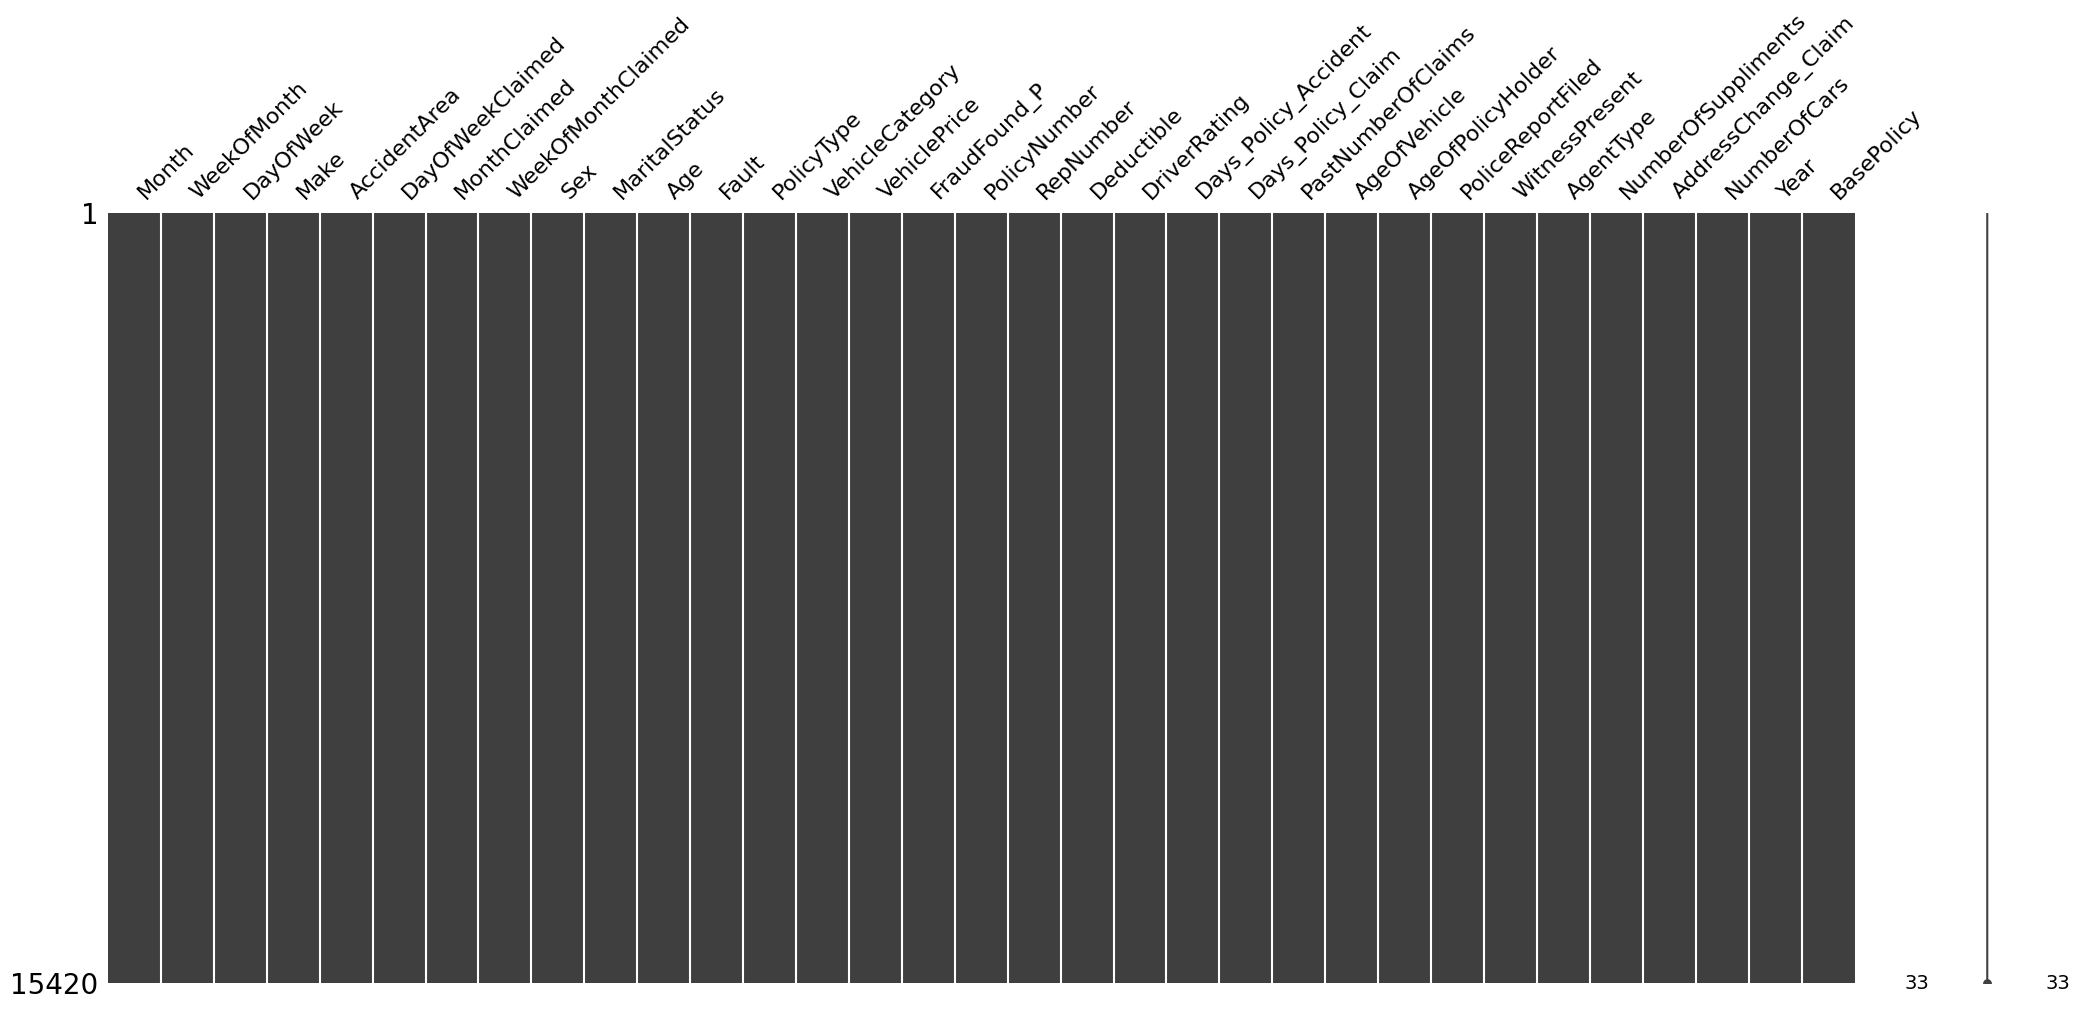

In [6]:
msno.matrix(raw_data)

#### **Point 01**: There is no missing value.

## 03) Characteristic of Dataset

In [7]:
# Function01: Summarize the characteristic of dataset
def summarize(DataFrame):
    
    summary = pd.DataFrame()
    
    # Data Type
    summary['Data Type'] = DataFrame.dtypes
    # N Unique
    summary['N Unique'] = DataFrame.nunique()
    # Unique
    summary['Unique'] = DataFrame.apply(lambda x: x.unique().tolist())
    # Max
    summary['Max'] = DataFrame.apply(lambda x: x.max() if pd.api.types.is_numeric_dtype(x) else '-')
    # Min
    summary['Min'] = DataFrame.apply(lambda x: x.min() if pd.api.types.is_numeric_dtype(x) else '-')
    
    # Measures of Central Tendency: Mean, Median, Mode 
    summary['Mean'] = DataFrame.apply(lambda x: round(x.mean(), 2) if pd.api.types.is_numeric_dtype(x) else '-')
    summary['Median'] = DataFrame.apply(lambda x: x.median() if pd.api.types.is_numeric_dtype(x) else '-')
    summary['Mode'] = DataFrame.apply(lambda x: x.mode().iloc[0] if not x.mode().empty else '-')
    
    # Measures of Dispersion: Range, Variance, Standard Deviation
    summary['Range'] = DataFrame.apply(lambda x: x.max() - x.min() if pd.api.types.is_numeric_dtype(x) else '-')
    summary['Variance'] = DataFrame.apply(lambda x: x.var() if pd.api.types.is_numeric_dtype(x) else '-')
    summary['Standard Deviation'] = DataFrame.apply(lambda x: x.std() if pd.api.types.is_numeric_dtype(x) else '-')
    
    # Measures of Shape: Skewness, Kurtosis
    summary['Skewness'] = DataFrame.apply(lambda x: round(x.skew(), 2) if pd.api.types.is_numeric_dtype(x) else '-')
    summary['Kurtosis'] = DataFrame.apply(lambda x: round(x.kurt(), 2) if pd.api.types.is_numeric_dtype(x) else '-')
    
    return summary

In [8]:
summary = summarize(raw_data)
summary

,Data Type,N Unique,Unique,Max,Min,Mean,Median,Mode,Range,Variance,Standard Deviation,Skewness,Kurtosis
Month,object,12,"[Dec, Jan, Oct, Jun, Feb, Nov, Apr, Mar, Aug, ...",-,-,-,-,Jan,-,-,-,-,-
WeekOfMonth,int64,5,"[5, 3, 2, 4, 1]",5,1,2.79,3.0,3,4,1.657876,1.287585,0.12,-1.1
DayOfWeek,object,7,"[Wednesday, Friday, Saturday, Monday, Tuesday,...",-,-,-,-,Monday,-,-,-,-,-
Make,object,19,"[Honda, Toyota, Ford, Mazda, Chevrolet, Pontia...",-,-,-,-,Pontiac,-,-,-,-,-
AccidentArea,object,2,"[Urban, Rural]",-,-,-,-,Urban,-,-,-,-,-
DayOfWeekClaimed,object,8,"[Tuesday, Monday, Thursday, Friday, Wednesday,...",-,-,-,-,Monday,-,-,-,-,-
MonthClaimed,object,13,"[Jan, Nov, Jul, Feb, Mar, Dec, Apr, Aug, May, ...",-,-,-,-,Jan,-,-,-,-,-
WeekOfMonthClaimed,int64,5,"[1, 4, 2, 3, 5]",5,1,2.69,3.0,2,4,1.585371,1.259115,0.16,-1.09
Sex,object,2,"[Female, Male]",-,-,-,-,Male,-,-,-,-,-
MaritalStatus,object,4,"[Single, Married, Widow, Divorced]",-,-,-,-,Married,-,-,-,-,-


#### **Point 02**: "PolicyNumber" is merely an identification number. Let's drop it.
#### **Point 03**: The features "Sex", "PoliceReportFiled", and "WitnessPresent" are actually **Boolen Types**. Should be converted to 0 or 1.
#### **Point 04**: The features "AccidentalArea", "Fault", and "AgentType" each have only two unique values. Can also be converted to 0 or 1.
#### **Point 05**: The minimum value of "Age" is 0. It totally doesn't make sense. (Let me look into it later.)
#### **Point 06**: The features "FraudFound_P" and "Deductible" are highly skewed; Typically, a feature is considered skewed if its skewness falls outside the range of -0.5~0.5.
#### **Point 07**: The features "WeekOfMonth", "WeekOfMonthClaimed", "FraudFound_P", "Deductible", and "DriverRating" exhibit high kurtosis; Typically a feature is considered to have high kurtosis if its value falls outside the range of -1 ~ 1.
#### **Point 08**: Strictly speaking, among all the features, only Age is a numeric variable. The rest can be interpreted as categorical variables.

# 🔎**02. Exploratory Data Analysis (EDA)**🔎

#### **What is Exploratory Data Analysis (EDA)?**
Exploratory Data Analysis (EDA) is the process of analyzing datasets to summarize their main characteristics, often using visual methods. It helps in understanding the data structure, identifying patterns, spotting anoalies, and checking assumptions with the help of summary statistics and graphical representations.

#### **Why is EDA Necessary?**
* **Data Understanding**: EDA provides insights into the dataset, helping to understand its structure, distribution, and inherent patterns.
* **Problem Indentification**: It helps identify issues such as missing values, outliers, and anomalies that need to be addressed during data preprocessing.
* **Informing Modeling Strategies**: Understanding the data helps in choosing the appropriate modeling techniques and preprocessing steps.
* **Insight Discovery**: EDA can reveal hidden patterns and relationships within the data, providing valuable insights for decision-making and strategy formulation.

In [9]:
df_viz = raw_data.copy()
df_viz.shape

(15420, 33)

## 01) Target Variable Balance - Fraud_Found_P

In [10]:
fraud_counts = df_viz['FraudFound_P'].value_counts().reset_index()
fraud_counts.columns = ['FraudFound_P', 'Count']
fraud_counts

,FraudFound_P,Count
0,0,14497
1,1,923


In [11]:
# Pie Chart
fig = px.pie(fraud_counts, names='FraudFound_P', values='Count', color='FraudFound_P',
            color_discrete_map={0: '#87CEFA', 1:'FF6F61'})

fig.update_traces(
    textinfo='percent',
    textfont={'size': 16, 'color': 'Black'},
    marker=dict(line=dict(color='black', width=2)))

fig.update_layout(
    title={
        'text': 'Target Balance',
        'x':0.5,
        'font': {'family': "Arial, sans-serif", 'size': 24}
    })

fig.show()

#### **Point 09**: The Target Variable "Fraud_Found_P" is **highly imbalanced**.

#### **Issues Caused by Imbalanced Target Variable**
* **Model Bias**: The model may become biased towards the majority class, leading to poor performance on the minority class.
* **Misleading Metrics**: Metrics like accuracy can be misleading, as high accuracy can be achieved by simply predicting the majority class.
* **Poor Generalization**: The model may not generalize well to real-world scenarios where the minority class is important.

#### **Necessity of Oversampling**
Oversampling address these issues by balancing the dataset, which helps the model to learn from both classes more effectively. This improves the model's ability to correctly predict the minority class, leading to better overall performance and more reliable evaluation metrics.

* **Impoved Model Performance**: In cases of severe class imbalance, the model may become biased towards the majority class, leading to poor performance on the minority class. Oversampling helps mitigate this issue, enhancing the overall performance of the model.
* **Enhanced Evaluation Metrics**: With severe class imbalance, metrics like accuracy can be misleading. Oversampling allows for more accurate assessment of metrics such as Precision, Recall, and F-1 Score.
* **Balanced Learning**: Balancing the dataset ensures that the model learns from all classes evenly. This leads to better performance across various scenarios when the model is deployed in real-world applications.

#### *I will perform "Oversampling" in the Data Preprocessing part.*

## 02) Fraud Detection by Sex

In [12]:
df_fraud = df_viz[df_viz['FraudFound_P'] == 1]

fraud_counts_sex = df_fraud['Sex'].value_counts()
fraud_percentages_sex = (fraud_counts_sex / fraud_counts_sex.sum()) * 100
fraud_percentages_sex

# Bar Chart
fig = go.Figure()

fig.add_trace(go.Bar(x=fraud_counts_sex.index, y=fraud_counts_sex.values,
                    text=[f'{count} ({percentage:.2f}%)' for count, percentage in zip(fraud_counts_sex.values, fraud_percentages_sex)],
                    textposition='auto', marker_color=['rgba(31, 119, 180, 0.6)', 'rgba(255, 127, 14, 0.6)'], width=0.5))

fig.update_layout(
    title={
        'text': 'Fraud Detection by Age',
        'x':0.5,
        'font': {'family': "Arial, sans-serif", 'size': 24}
    })

fig.update_layout(
    xaxis=dict(title='Sex'),
    yaxis=dict(title='Count'),
    showlegend=False)

fig.show()

#### **Point 10**: This results suggest that males are significantly more likely to be involved in detected fraud cases compared to females.

## 03) Fraud Detection by Age & Age of Policy Holder

In [13]:
df_fraud = df_viz[df_viz['FraudFound_P'] == 1]
df_non_fraud = df_viz[df_viz['FraudFound_P'] == 0]

df_counts_age = df_viz['Age'].value_counts().sort_index()
df_counts_fraud = df_fraud['Age'].value_counts().sort_index()

df_percentages_fraud = round((df_counts_fraud / df_counts_age) * 100, 2)

# Bar Chart
fig = go.Figure()

fig.add_trace(go.Bar(x=df_percentages_fraud.index, y=df_percentages_fraud.values,
    marker_color='rgba(31, 119, 180, 0.7)'))

fig.update_layout(
    title={
        'text': 'Fraud Detection by Age',
        'x':0.5,
        'font': {'family': "Arial, sans-serif", 'size': 24}
    })

fig.update_layout(
    xaxis=dict(title='Age'), yaxis=dict(title='Percentage', range=[0, 20], dtick=2), legend=dict(title='Outcome'))

fig.add_shape(
    type="line",
    x0=min(df_percentages_fraud.index),
    y0=6,
    x1=max(df_percentages_fraud.index),
    y1=6,
    line=dict(
        color="rgba(255, 0, 0, 0.8)",
        width=2,
        dash="dashdot",
    ),
)

fig.show()

In [14]:
df_fraud = df_viz[df_viz['FraudFound_P'] == 1]
df_non_fraud = df_viz[df_viz['FraudFound_P'] == 0]

df_counts_ageofpolicyholder = df_viz['AgeOfPolicyHolder'].value_counts().sort_index()
df_counts_fraud_ = df_fraud['AgeOfPolicyHolder'].value_counts().sort_index()

df_percentages_fraud_ = round((df_counts_fraud_ / df_counts_ageofpolicyholder) * 100, 2)

# Bar Chart
fig = go.Figure()

fig.add_trace(go.Bar(x=df_percentages_fraud_.index, y=df_percentages_fraud_.values,
    marker_color='rgba(31, 119, 180, 0.7)'))

fig.update_layout(
    title={
        'text': 'Fraud Detection by Age of Policy Holder',
        'x':0.5,
        'font': {'family': "Arial, sans-serif", 'size': 24}
    })

fig.update_layout(
    xaxis=dict(title='Age of Policy Holder'), yaxis=dict(title='Percentage', range=[0, 20], dtick=2), legend=dict(title='Outcome'))

fig.add_shape(
    type="line",
    x0=-1,
    y0=6,
    x1=10,
    y1=6,
    line=dict(
        color="rgba(255, 0, 0, 0.8)",
        width=2,
        dash="dashdot",
    ),
)

fig.show()

#### **Point 11-1**: Fraud is most frequently detected among **teenagers** and **retired seniors**. Teenagers have weak financial power as they have not yet started their economic activities, and retired seniors experience weakened financial power post-retirement. Considering these points, there seems to be a correlation between financial power and fraud. 
#### **Point 11-2**: Conversely, **only the under-25 age group** exhibits a high fraud rate in "Age of Policy Holder feature.

## 04) Fraud Detection by Make

In [15]:
df_counts_make = df_viz['Make'].value_counts().sort_index()
df_counts_fraud2 = df_fraud['Make'].value_counts().sort_index()
df_percentages_fraud2 = pd.DataFrame(round((df_counts_fraud2 / df_counts_make) * 100, 2)).fillna(0).reset_index()

df_percentages_fraud2.columns = ['Make', 'Fraud %']
df_percentages_fraud2 = df_percentages_fraud2.sort_values(by=['Fraud %', 'Make'])

# Bar Chart
fig = go.Figure()

fig.add_trace(go.Bar(x=df_percentages_fraud2['Fraud %'], y=df_percentages_fraud2['Make'], orientation='h',
    marker_color='lightcoral'))

fig.update_layout(
    title={
        'text': 'Fraud Detection by Make',
        'x':0.5,
        'font': {'family': "Arial, sans-serif", 'size': 24}
    })

fig.update_layout(
    xaxis=dict(title='Percentage', range=[0, 30], dtick=2), yaxis=dict(title='Make'), legend=dict(title='Outcome'), bargap=0.3)

fig.add_shape(
    type="line",
    x0=6,
    y0=0,
    x1=6,
    y1=len(df_percentages_fraud2['Make']) - 1,
    line=dict(
        color="rgba(128, 128, 128, 1)",
        width=2,
        dash="dashdot", 
    ),
)

fig.show()

#### **Point 12**: The **Mecedes owners** are more likely to be involved in fraud,with almost double the incidence compared to the second-highest group, Accura owners. On the other hand, the Porche, Lexus, Jaguar, Ferrari owners have never been reported for fraud; all the four make are "High-End".

## 05) Fraud Detection by Vehicle Price

In [16]:
df_counts_vp = df_viz['VehiclePrice'].value_counts().sort_index()
df_counts_fraud3 = df_fraud['VehiclePrice'].value_counts().sort_index()
df_percentages_fraud3 = pd.DataFrame(round((df_counts_fraud3 / df_counts_vp) * 100, 2)).fillna(0).reset_index()

df_percentages_fraud3.columns = ['VehiclePrice', 'Fraud %']
df_percentages_fraud3 = df_percentages_fraud3.sort_values(by=['Fraud %'])

# Bar Chart
fig = go.Figure()

fig.add_trace(go.Bar(x=df_percentages_fraud3['Fraud %'], y=df_percentages_fraud3['VehiclePrice'], orientation='h',
    marker_color='#9FF781'))

fig.update_layout(
    title={
        'text': 'Fraud Detection by VehiclePrice',
        'x':0.5,
        'font': {'family': "Arial, sans-serif", 'size': 24}
    })

fig.update_layout(
    xaxis=dict(title='Percentage', range=[0, 16], dtick=2), yaxis=dict(title='VehiclePrice'), legend=dict(title='Outcome'), bargap=0.3)

fig.add_shape(
    type="line",
    x0=6,
    y0=0,
    x1=6,
    y1=5.5,
    line=dict(
        color="rgba(0, 100, 0, 1)",
        width=2,
        dash="dashdot", 
    ),
)

fig.show()

#### **Point 13**: Fraudulent cases were detected most frequently in either the most expensive or the cheapest vehicle category.

## 06) Fraud Detection by BasePolicy & PolicyType

In [17]:
# BasePolicy
df_counts_policy = df_viz['BasePolicy'].value_counts().sort_index()
df_counts_fraud4 = df_fraud['BasePolicy'].value_counts().sort_index()
df_percentages_fraud4 = pd.DataFrame(round((df_counts_fraud4 / df_counts_policy) * 100, 2)).fillna(0).reset_index()

df_percentages_fraud4.columns = ['BasePolicy', 'Fraud %']
df_percentages_fraud4 = df_percentages_fraud4.sort_values(by=['Fraud %'])

# PolicyType
df_counts_policy2 = df_viz['PolicyType'].value_counts().sort_index()
df_counts_fraud5 = df_fraud['PolicyType'].value_counts().sort_index()
df_percentages_fraud5 = pd.DataFrame(round((df_counts_fraud5 / df_counts_policy2) * 100, 2)).fillna(0).reset_index()

df_percentages_fraud5.columns = ['PolicyType', 'Fraud %']
df_percentages_fraud5 = df_percentages_fraud5.sort_values(by=['Fraud %'])

# Bar Chart - Subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=('BasePolicy', "PolicyType"))

fig.add_trace(go.Bar(x=df_percentages_fraud4['BasePolicy'], y=df_percentages_fraud4['Fraud %'],
    marker_color='skyblue'), row=1, col=1)

fig.add_trace(go.Bar(x=df_percentages_fraud5['PolicyType'], y=df_percentages_fraud5['Fraud %'],
    marker_color='coral'), row=1, col=2)

fig.update_layout(
    title={
        'text': 'Fraud Detection by BasePolicy & PolicyType',
        'x':0.5,
        'font': {'family': "Arial, sans-serif", 'size': 24}
    }, showlegend=False)

fig.add_shape(
    type="line",
    x0=-1,
    y0=6,
    x1=3,
    y1=6,
    line=dict(
        color="rgba(128, 128, 128, 1)", 
        width=2,
        dash="dashdot",
    ),
    xref="x1",
    yref="y1"
)

fig.add_shape(
    type="line",
    x0=-1,
    y0=6,
    x1=9,
    y1=6,
    line=dict(
        color="rgba(128, 128, 128, 1)", 
        width=2,
        dash="dashdot",
    ),
    xref="x2",
    yref="y2"
)

fig.show()

#### **Point 14**: Fraudulentcsaes were detected most frequently under the "All Perils". Witin specificy policy types, "Sport-Collsion" had the highest fraud detection rate.

## 07) Fraud Detection by Age of Vehicle

In [18]:
# Age of Vehicle
df_counts_ageofvehicle = df_viz['AgeOfVehicle'].value_counts().sort_index()
df_counts_fraud6 = df_fraud['AgeOfVehicle'].value_counts().sort_index()
df_percentages_fraud6 = pd.DataFrame(round((df_counts_fraud6 / df_counts_ageofvehicle) * 100, 2)).fillna(0).reset_index()

df_percentages_fraud6.columns = ['AgeOfVehicle', 'Fraud %']
df_percentages_fraud6 = df_percentages_fraud6.sort_values(by=['Fraud %'])

# Bar Chart
fig = go.Figure()

fig.add_trace(go.Bar(x=df_percentages_fraud6['Fraud %'], y=df_percentages_fraud6['AgeOfVehicle'], orientation='h',
    marker_color='rgb(255, 165, 0)'))

fig.update_layout(
    title={
        'text': 'Fraud Detection by Age of Vehicle',
        'x':0.5,
        'font': {'family': "Arial, sans-serif", 'size': 24}
    })

fig.update_layout(
    xaxis=dict(title='Percentage', range=[0, 16], dtick=2), yaxis=dict(title='AgeOfVehicle'), legend=dict(title='Outcome'), bargap=0.3)

fig.add_shape(
    type="line",
    x0=6,
    y0=-1,
    x1=6,
    y1=8,
    line=dict(
        color="rgba(0, 100, 0, 1)",
        width=2,
        dash="dashdot", 
    ),
)

fig.show()

#### **Point 15**: The feature "AgeOfVehicle" actually can be re-classified into 3 categories; The higest, mid, and low fraudulent groups.

## 08) Fraud Detection by Month & MonthClaimed

In [19]:
# Month
df_counts_month = df_viz['Month'].value_counts().sort_index()
df_counts_fraud7 = df_fraud['Month'].value_counts().sort_index()
df_percentages_fraud7 = pd.DataFrame(round((df_counts_fraud7 / df_counts_month) * 100, 2)).fillna(0).reset_index()

df_percentages_fraud7.columns = ['Month', 'Fraud %']

# MonthClaimed
df_counts_monthclaimed = df_viz['MonthClaimed'].value_counts().sort_index()
df_counts_fraud8 = df_fraud['MonthClaimed'].value_counts().sort_index()
df_percentages_fraud8 = pd.DataFrame(round((df_counts_fraud8 / df_counts_monthclaimed) * 100, 2)).fillna(0).reset_index()

df_percentages_fraud8.columns = ['MonthClaimed', 'Fraud %']

month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Bar Chart - Subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=('Month', "MonthClaimed"))

fig.add_trace(go.Bar(x=df_percentages_fraud7['Month'], y=df_percentages_fraud7['Fraud %'],
    marker_color='#8A2BE2'), row=1, col=1)

fig.add_trace(go.Bar(x=df_percentages_fraud8['MonthClaimed'], y=df_percentages_fraud8['Fraud %'],
    marker_color='#FF4500'), row=1, col=2)

fig.update_layout(
    title={
        'text': 'Fraud Detection by Month & MonthClaimed',
        'x':0.5,
        'font': {'family': "Arial, sans-serif", 'size': 24}
    }, showlegend=False,
    xaxis=dict(categoryorder='array', categoryarray=month_order),
    xaxis2=dict(categoryorder='array', categoryarray=month_order))

fig.add_shape(
    type="line",
    x0=-1,
    y0=6,
    x1=12,
    y1=6,
    line=dict(
        color="rgba(128, 128, 128, 1)", 
        width=2,
        dash="dashdot",
    ),
    xref="x1",
    yref="y1"
)

fig.add_shape(
    type="line",
    x0=-1,
    y0=6,
    x1=12.5,
    y1=6,
    line=dict(
        color="rgba(128, 128, 128, 1)", 
        width=2,
        dash="dashdot",
    ),
    xref="x2",
    yref="y2"
)

fig.show()

#### **Point 16**: The features have similar distributions. (We don't need both.)

# 🔄**03. Data Preprocessing**🔄

#### **What is Data Preprocessing?**
Data Preprocessing is the process of transforming raw data into a clean and usable format for analysis or machine learning models. It involves several steps to ensure the data is accurate, consistent, and ready for further processing. <br/>
Here are the main components of data preprocessing:
* **01) Data Cleaning**: Handling Missing Values, Removing Duplicates, Correcting Inaccurate Data, Ensuring Consistency, Handling Outliers
* **02) Data Integration**: Combining data from different sources into a coherent dataset.
* **03) Data Transformation**: Normalization and Scaling, Encoding Categorical Variable, Feature Engineering, Aggregation
* **04) Data Reduction**: Dimensionality Reduction, Feature Selection, Sampling
* **05) Data Discretization**: Converting continous data into discrete buckets
* **06) Data Splitting**: Dividing data into training, validation, and test sets.

#### In this prodject, I will use some of the necessary techniques.

In [20]:
df_clean_v1 = raw_data.copy()
df_clean_v1.shape

(15420, 33)

## 01) Data Transformation - Encoding Categorical Variables (**Binary Variable**) - Label Encoding
* AccidentArea, Sex, Fault, PoliceReportFiled, WitnessPresent, AgentType

These features have only two unique values.<br/>
Therefore, I applied **Label Encoding** to map them to 0 and 1.

In [21]:
binary_columns = [col for col in df_clean_v1.columns if df_clean_v1[col].nunique() == 2 and col != 'FraudFound_P']

In [22]:
print('The number of Binary Columns: ', len(binary_columns))
print('Binary Columns: ', binary_columns)

The number of Binary Columns:  6
Binary Columns:  ['AccidentArea', 'Sex', 'Fault', 'PoliceReportFiled', 'WitnessPresent', 'AgentType']


In [23]:
le = LabelEncoder()

for col  in binary_columns:
    df_clean_v1[col] = le.fit_transform(df_clean_v1[col])
    print('Label Mapping: ', dict(zip(le.classes_, le.transform(le.classes_))))

Label Mapping:  {'Rural': 0, 'Urban': 1}
Label Mapping:  {'Female': 0, 'Male': 1}
Label Mapping:  {'Policy Holder': 0, 'Third Party': 1}
Label Mapping:  {'No': 0, 'Yes': 1}
Label Mapping:  {'No': 0, 'Yes': 1}
Label Mapping:  {'External': 0, 'Internal': 1}


## 02) Data Transformation - Encoding Categorical Variables (**Ordinal Categorical Variables** & **Nominal Categorical Variables**) - Label Encoding
* VehiclePrice, DriverRating, AgeOfVehicle, BasePolicy

An **Ordinal Categorical Variable** is a categorical variable where the categories have a logical order or ranking (e.g., low, medium, high).
When performing **Lebel Encoding** on ordinal categorical variables, consider the following:
* **Maintain Order**: Ensure the encoding reflects the natural order of the categories.
* **Custom Mapping**: Use a custom dictionary to map categories to integers that respect the order.
* **Model Interpretation**: Ensure the model understands the encoded values represent an order, not arbitrary numbers.
* **Consistency**: Apply the encoding consistently across the dataset.

A **Nominal Categorical Variable** is a categorical variable where the categories do not have a logical order or ranking (e.g., red, blue, green). 

In [24]:
for col in ['VehiclePrice', 'DriverRating', 'AgeOfVehicle', 'BasePolicy']:
    print(f"The unique values in {col}: {df_clean_v1[col].unique()}")

The unique values in VehiclePrice: ['more than 69000' '20000 to 29000' '30000 to 39000' 'less than 20000'
 '40000 to 59000' '60000 to 69000']
The unique values in DriverRating: [1 4 3 2]
The unique values in AgeOfVehicle: ['3 years' '6 years' '7 years' 'more than 7' '5 years' 'new' '4 years'
 '2 years']
The unique values in BasePolicy: ['Liability' 'Collision' 'All Perils']


* The feature "DriverRating" is already a numeric feature, so I didn't transform it.
* I converted "VehiclePrice" into a binary variable rather than an ordinal one. This decision was based on the fact that the categories "more than 69000" and "less than 20000" have the highest fraud rates, showing that the feature does not follow an ordinal pattern. (Please refer to **Visualization 5**)
* I transformed "AgeOfVehicle" into a nominal categorical variable for the same reason as "VehiclePrice." However, this feature can be re-classified into three categories. (Please refer to **Visualization 7**)
* Only, "BasePolicy" keeps its natural characteristic as a ordinal categorical variable. (Please refer to **Visualization 6**)

In [25]:
vehicleprice_label = {'more than 69000': 1, '20000 to 29000': 0,  '30000 to 39000': 0, 'less than 20000': 1, '40000 to 59000': 1, '60000 to 69000': 0}
ageofvehicle_label = {'new': 2, '2 years': 0, '3 years': 2, '4 years': 2, '5 years': 1, '6 years': 1, '7 years': 0, 'more than 7': 0}
basepolicy_label = {'Liability': 0, 'Collision': 1, 'All Perils': 2}

In [26]:
df_clean_v1['VehiclePrice'] = df_clean_v1['VehiclePrice'].map(vehicleprice_label)
df_clean_v1['AgeOfVehicle'] = df_clean_v1['AgeOfVehicle'].map(ageofvehicle_label)
df_clean_v1['BasePolicy'] = df_clean_v1['BasePolicy'].map(basepolicy_label)

In [27]:
df_clean_v2 = df_clean_v1.copy()
df_clean_v2.shape

(15420, 33)

## 03) Data Reduction - Feature Selection 01 (Drop Useless Columns)

* I dropped "Month" because we already have similar feature "MonthClaimed" (Please refer to **Visualization 8**)
* Also, I dropped other features related to "Date".

In [28]:
useless_columns = ['Month', 'WeekOfMonth', 'DayOfWeek', 'DayOfWeekClaimed', 'WeekOfMonthClaimed', 'PolicyNumber']
df_clean_v3 = df_clean_v2.drop(columns=useless_columns, axis=1)
df_clean_v3.shape

(15420, 27)

## 04) Data Transformation - One-hot Endoing (Other categorical variables)

#### **What is One-hot Encoding?**
**One-hot encoding** is a process used to convert categorical data into a binary (0 or 1) format that can be used in machine learning models. In one-hot encoding, each category is represented by a binary vector with the length equal to the number of categories. In this vector, all elements are 0 except for the element corresponding to the particular category, which is set to 1.

For example, if we have three categories: "Red", "Green", and "Blue", they can be one-hot encoded as follows:

"Red" -> [1, 0, 0]
"Green" -> [0, 1, 0]
"Blue" -> [0, 0, 1]


This method is useful because it allows categorical data to be represented numerically in a way that machine learning algorithms can utilize effectively.

I changed datatypes of some features into **"string"** before performing One-hot Encoding to correct identification of categoris.

In [29]:
dtype_change_string = ['RepNumber', 'Deductible', 'Year']

for col in dtype_change_string:
    df_clean_v3[col] = df_clean_v3[col].astype(str)

In [30]:
onehot_encoding_columns = ['Make', 'MonthClaimed', 'MaritalStatus', 'PolicyType', 'VehicleCategory', 'RepNumber', 'Deductible', 'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfPolicyHolder', 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'Year']
print("The number of one-hot encoding target features: ", len(onehot_encoding_columns))

The number of one-hot encoding target features:  15


In [31]:
df_clean_v4 = pd.get_dummies(df_clean_v3, columns=onehot_encoding_columns)
df_clean_v4.shape

(15420, 119)

#### Now, all features' datatypes are **"Integer"** or **"Boolean"**

## 05) Data Reduction - Feature Selection 02 (Drop Constant Features)

In [32]:
onehot_encoded_columns = [col for col in df_clean_v4.columns if '_' in col]
onehot_encoded_columns.remove("FraudFound_P")
print("The Number of One-hot Encoded Columns: ", len(onehot_encoded_columns))

The Number of One-hot Encoded Columns:  107


In [33]:
constant_features = []
for col in onehot_encoded_columns:
    if df_clean_v4[col].sum() <= 5:
        constant_features.append(col)
print("The Number of Constant Features: ", len(constant_features))

The Number of Constant Features:  9


In [34]:
df_clean_v4.drop(columns=constant_features, axis=1, inplace=True)
df_clean_v4.shape

(15420, 110)

## 06) Data Cleaning - Correcting Inaccurate Data & Handling Outliers (Age) - **Outlier Replacement using LightGBM**

#### It's time to handle "Age", the only continuous feature in this dataset.

In [35]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("Histogram of Age", "Box Plot of Age"))

# Histogram
fig.add_trace(go.Histogram(x=df_viz['Age'], nbinsx=100), row=1, col=1)
# Box Plot
fig.add_trace(go.Box(x=df_viz['Age']), row=1, col=2)

fig.update_layout(
    title={
        'text': 'Distribution of Age', 'x':0.5,
        'xanchor': 'center', 'yanchor': 'top',
        'font': {'family': 'Arial, sans-serif', 'size': 24}
    }, showlegend=False
)

fig.show()

#### As I mentioned above, it doesn't make sense to include 0 values. This dataset is "Vehicle Claim Fraud Detection!" (Please refer to **Point05**)
* I decided to handle the 0s in this feature and outliers at the same time.
* I performed Random Forest Imputation to change 0s and outliers (Over 74).

#### **What is Outlier Replacement using LightGBM?**

This method leverages LightGBM's predictive power to estimate and replace outliers, ensuring the imputed values are consistent with the rest of the data.

#### **Why Use LightGBM for Outlier Replacement**
* **High Accuracy**: Captures complex patterns and non-linear relationships.
* **Efficiency**: Fast training and scalable for large datasets.
* **Built-in Handling of Missing Values**: Natively manages missing data. 
* **Regularization**: Prevents overfitting.


In [36]:
# Function02: Outlier Replacement using LightGBM
def lightgbm_imputation(dataframe, feature):
    df_copy = dataframe.copy()
    train_data = df_copy[df_copy[feature].notnull()]
    test_data = df_copy[df_copy[feature].isnull()]
    
    X_train = train_data.drop(columns=[feature], axis=1)
    y_train = train_data[feature]
    X_test = test_data.drop(columns=[feature], axis=1)
    
    train_dataset = lgb.Dataset(X_train, label=y_train)
    
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'verbose': -1
    }
    
    model = lgb.train(params, train_dataset, num_boost_round=100)
    
    predictions = model.predict(X_test)
    
    df_copy.loc[df_copy[feature].isnull(), feature] = predictions
    
    return df_copy

In [37]:
# Change 0s and outliers into NullValues
df_clean_v4['Age'] = df_clean_v4['Age'].apply(lambda x: np.nan if x == 0 or x > 74 else x)

In [38]:
# Apply LightGBM Imputation
df_imputed = lightgbm_imputation(df_clean_v4, 'Age')

In [39]:
# Round up floats
df_imputed['Age'] = df_imputed["Age"].apply(lambda x: round(x))

#### After I finished the work, I transoformed the continuous variable into categorial variable based on the **Visualization 3**.

In [40]:
# Function03: Categorize Age
def categorize_age(age):
    if age <= 20:
        return 0
    elif age <= 40:
        return 1
    elif age <= 65:
        return 2
    else:
        return 3

In [41]:
df_imputed['Age'] = df_imputed['Age'].apply(categorize_age)

In [42]:
df_clean_v5 = df_imputed.copy()
df_clean_v5.shape

(15420, 110)

# ⚙️**04. SMOTE Oversampling - Synthetic Minority Oversampling Technique**⚙️

The **Synthetic Minority Over-sampling Technique (SMOTE)** is a method used in machine learning to address the issue of imbalanced datasets. Imbalanced datasets are common in classification problems, especially **Fraud Detection datasets**, where one class (often the minority class) has significantly fewer instances than the other class(es). SMOTE aims to balance the class distribution by generating synthetic examples from the minority class.

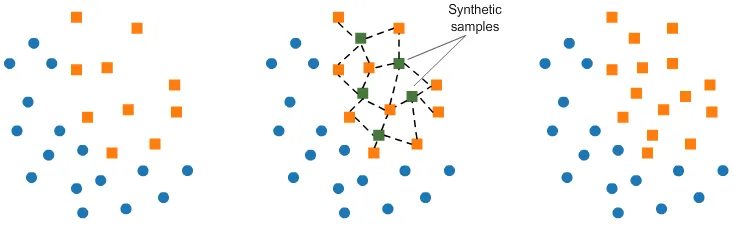

* **Image Source**: https://medium.com/@asheshdas.ds/oversampling-to-remove-class-imbalance-using-smote-94d5648e7d35

In [43]:
# Train - Test Split
X = df_clean_v5.drop(columns="FraudFound_P")
y = df_clean_v5["FraudFound_P"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

print("Before SMOTE: ", X_train.shape, y_train.shape)
print("After Smote: ", X_train_over.shape, y_train_over.shape)
print()
print("After SMOTE Label Distribution: ", pd.Series(y_train_over).value_counts())

Before SMOTE:  (12336, 109) (12336,)
After Smote:  (23220, 109) (23220,)

After SMOTE Label Distribution:  FraudFound_P
0    11610
1    11610
Name: count, dtype: int64


In [45]:
df_smote = pd.concat([X_train_over, y_train_over], axis=1)
df_smote.shape

(23220, 110)

#### Now, we have **Balanced Dataset**!

# ✅**05. RFECV Feature Selection - Recursive Feature Elimination Cross Validation (+ VarianceThreshold Method)**✅

#### **What is Recursive Feature Elimination Cross Validation (RFECV)?**
**Recursive Feature Elimination Cross Validation (RFECV)** is a feature selection method that recursively removes less important features based on a specified estimator's performance. It combines the process of Recursive Feature Elimination (RFE) with Cross-Validation (CV) to determine the optimal number of features that yield the best model performance.

* **Reference**: Feature Selection Explained: RFECV by **AVANISHMEED** (Link: https://www.kaggle.com/code/avanishmeed/feature-selection-explained-rfecv)

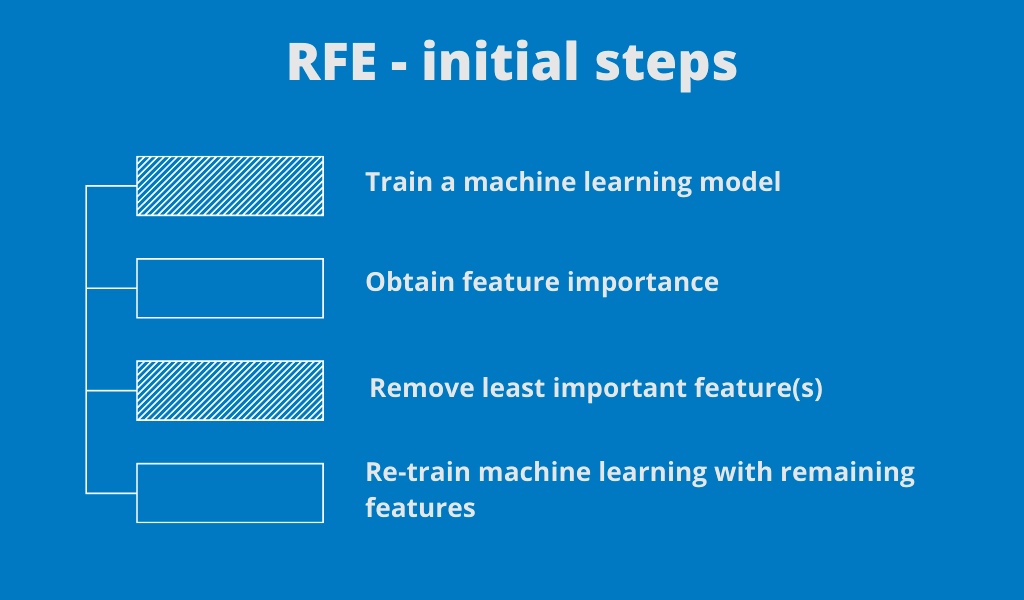

* **Image Source:https://www.analyticsvidhya.com/blog/2023/05/recursive-feature-elimination/**

In [46]:
X_smote = df_smote.drop(columns="FraudFound_P")
y_smote = df_smote["FraudFound_P"]
print(X_smote.shape, y_smote.shape)

(23220, 109) (23220,)


#### Before moving forward to the RFECV, I performed Pre-feature-selection using **VarianceThreshold**
**VarianceThreshold** is a feature selection method that removes features with low variance. Features with variance below a specified threshold are considered to have little informational value because they exhibit little variability across samples.
* **Reduce noise** Eliminates features that do not vary much, wichi are less likely to be informative.
* **Simplifies the model**: Reduces the number of features, making the model simpler and faster. (This is the reason I performed this before RFECV!)
* **Prevents overfitting**: Helps in reducing the risk of overfitting by removing uninformative features.

In [47]:
# VarianceThreshold
selector = VarianceThreshold(threshold=0.01) # The larger the threshold, the more features are eliminated.
X_reduced = selector.fit_transform(X_smote)
X_reduced.shape

(23220, 82)

In [48]:
selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = X_smote.columns[selected_feature_indices]
X_reduced = pd.DataFrame(X_reduced, columns=selected_feature_names)

#### **Now, let's play with RFECV!**

#### You can use any classifier to perform RFECV. I chose **LightGBM** because my dataset contains many categorical variables. 
* **CatBoost algorithm** is better in hanlding categorical variables than LightGBM, but the **CatBoost algorithm** costs computing resource too much.

In [49]:
# LigthGBM
lightgbm_model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42, verbose=-1)

#### I used **ROC_AUC** as a scoring parameter because, in fraud detection, it is important to consider both accuracy and recall. For more details about scoring metrics, please click the following link: https://www.v7labs.com/blog/f1-score-guide

In [50]:
rfecv = RFECV(estimator=lightgbm_model, step=1, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=-1)
rfecv.fit(X_reduced, y_smote)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LGBMClassifier(random_state=42, verbose=-1), n_jobs=-1,
      scoring='roc_auc')

In [51]:
# The Selected features
optimal_num_features =rfecv.n_features_
print(f"Optimal number of features: {optimal_num_features}")

Optimal number of features: 62


In [52]:
X_selected = rfecv.transform(X_reduced)

In [53]:
selected_feature_indices = np.where(rfecv.support_)[0]
selected_feature_names = X_reduced.columns[selected_feature_indices]
X_rfecv = pd.DataFrame(X_selected, columns=selected_feature_names)

# 🤖**06. Modeling - Optimization using Optuna**🤖

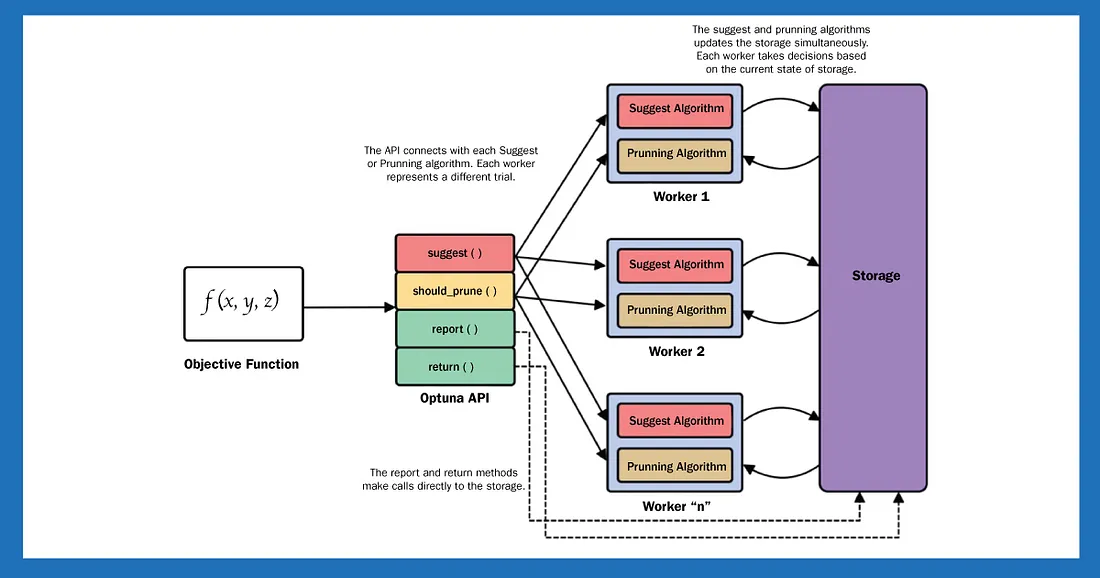

* **Image Source**: https://medium.com/@publiciscommerce/optuna-an-automatic-hyperparameter-optimization-framework-f64638621ff7

#### **What is Optuna**?
**Optuna** is an automatic hyperparameter optimization framework designed to enhance the performance of machine learning models. It offers a flexible and efficient approach to finding the best hyperparameters by using techniques like **Bayesian Optimization**. Optuna allows users to define an objective function, which it then optimizes through a series of trials, intelligently searching the hyperparameter space. 

#### In summary, **Optuna** is a more advanced and efficient tool for hyperparameter optimization compared to GridSearch, offering flexibility, intelligent sampling, and resource-saving features like pruning.

* **Reference**: https://medium.com/@publiciscommerce/optuna-an-automatic-hyperparameter-optimization-framework-f64638621ff7

#### **Why Optuna is Powerful? (Comparing to GridSearch)**
* **Efficiency**: Unlike GridSearch, which exhaustively searches through all possible combinations of hyperparameters, Optuna uses intelligent algorithms to sample promising hyperparameter configurations, significantly reducing the search time and computational cost.
* **Flexibility**: Optuna supports various optimization algorithms and allows for complex search spaces, including conditional hyperparameters. This flexibility is not as easily achievable with GridSearch.
* **Pruning**: Optuna includes pruning features that stop unpromising trials early based on intermediate results, saving time and resources. GridSearch does not have built-in pruning mechanisms.
* **Visualization**: Optuna provides powerful visualization tools to analyze the optimization process, helping users understand the search behavior and performance improvements.

#### **Algorithms**
* **Logistics Regression**: A linear model for binary classification that predicts probabilities.
* **Support Vector Machine (SVM)**: Classifies data by finding the hyperplane that maximizes the margin between classes.
* **K-Nearest Neighbors (KNN)**: Predicts the class based on the majority class among the k nearest neighbors.
* **RandomForest**: An ensemble of decision trees that improves classification accuracy by averaging multiple trees.
* **LightGBM**:A gradient boosting framework that uses tree-based learning algorithms, optimized for speed and efficiency.
* **CatBoost**: A gradient boosting algorithm that handles categorical features automatically, designed for high performance and accuracy.

In [54]:
# X_rfecv_test
rfecv_columns = X_rfecv.columns.tolist()
X_rfecv_test = X_test[rfecv_columns]

## 01) Modeling - Optuna

In [55]:
# Function04: Objective
def objective(trial):
    classifier_name = trial.suggest_categorical('classifier', [
        'LogisticRegression', 'SVM', 'KNeighbors', 'RandomForest', 'LightGBM', 'CatBoost'
    ])
    
    if classifier_name == 'LogisticRegression':
        C = trial.suggest_float('lr_C', 0.1, 10)
        solver = trial.suggest_categorical('lr_solver', ['liblinear'])
        classifier_obj = LogisticRegression(C=C, solver=solver)
    
    elif classifier_name == 'SVM':
        C = trial.suggest_float('svm_C', 0.1, 10)
        kernel = trial.suggest_categorical('svm_kernel', ['linear', 'rbf'])
        classifier_obj = SVC(C=C, kernel=kernel, probability=True)
    
    elif classifier_name == 'KNeighbors':
        n_neighbors = trial.suggest_int('kn_n_neighbors', 3, 7)
        classifier_obj = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    elif classifier_name == 'RandomForest':
        n_estimators = trial.suggest_int('rf_n_estimators', 100, 200)
        max_depth = trial.suggest_categorical('rf_max_depth', [10, 20, None])
        classifier_obj = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    
    elif classifier_name == 'LightGBM':
        num_leaves = trial.suggest_int('lgb_num_leaves', 31, 50)
        learning_rate = trial.suggest_float('lgb_learning_rate', 0.01, 0.2)
        n_estimators = trial.suggest_int('lgb_n_estimators', 100, 200)
        classifier_obj = lgb.LGBMClassifier(num_leaves=num_leaves, learning_rate=learning_rate, n_estimators=n_estimators, verbose=-1)
    
    elif classifier_name == 'CatBoost':
        iterations = trial.suggest_int('cat_iterations', 100, 200)
        learning_rate = trial.suggest_float('cat_learning_rate', 0.01, 0.2)
        depth = trial.suggest_int('cat_depth', 3, 9)
        classifier_obj = CatBoostClassifier(iterations=iterations, learning_rate=learning_rate, depth=depth, verbose=0)
    
    classifier_obj.fit(X_rfecv, y_smote)
    y_prob = classifier_obj.predict_proba(X_rfecv_test)[:, 1]
    
    # Threshold optimization
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_threshold = 0.5
    best_score = 0.0
    
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        score = f1_score(y_test, y_pred)
        if score > best_score:
            best_score = score
            best_threshold = threshold
    
    trial.set_user_attr('best_threshold', best_threshold)
    trial.set_user_attr('classifier_obj', classifier_obj)
    return roc_auc_score(y_test, (y_prob >= best_threshold).astype(int))

In [56]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [57]:
# Optuna Study
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(objective, n_trials=100)

In [58]:
best_trial = study.best_trial
print('Best trial: ', best_trial.values)
print('Best hyperparameters: ', best_trial.params)

Best trial:  [0.773351220858777]
Best hyperparameters:  {'classifier': 'LightGBM', 'lgb_num_leaves': 50, 'lgb_learning_rate': 0.015153444286327866, 'lgb_n_estimators': 126}


In [59]:
# Optimized Alogrithm Combination
best_algorithms = [trial.params['classifier'] for trial in study.trials]
algorithm_counts = pd.Series(best_algorithms).value_counts()
print('Optimal algorithm proportions: ', algorithm_counts)

Optimal algorithm proportions:  LightGBM              60
CatBoost              11
KNeighbors             9
SVM                    7
LogisticRegression     7
RandomForest           6
Name: count, dtype: int64


In [60]:
# Function05: Evaluation
def evaluate_model(model, X_train, y_train, X_test, y_test, threshold):
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    return accuracy, precision, recall, f1, roc_auc

In [61]:
top_5_trials = study.trials_dataframe().sort_values(by='value', ascending=False).head(5)
results = []

for i, row in top_5_trials.iterrows():
    model_name = row['params_classifier']
    threshold = study.trials[row['number']].user_attrs['best_threshold']
    model_params = study.trials[row['number']].params

    if model_name == 'LogisticRegression':
        params = {'C': model_params['lr_C'], 'solver': model_params['lr_solver']}
        final_model = LogisticRegression(**params)
    elif model_name == 'SVM':
        params = {'C': model_params['svm_C'], 'kernel': model_params['svm_kernel']}
        final_model = SVC(**params, probability=True)
    elif model_name == 'KNeighbors':
        params = {'n_neighbors': model_params['kn_n_neighbors']}
        final_model = KNeighborsClassifier(**params)
    elif model_name == 'RandomForest':
        params = {'n_estimators': model_params['rf_n_estimators'], 'max_depth': model_params['rf_max_depth']}
        final_model = RandomForestClassifier(**params)
    elif model_name == 'LightGBM':
        params = {'num_leaves': model_params['lgb_num_leaves'], 'learning_rate': model_params['lgb_learning_rate'], 'n_estimators': model_params['lgb_n_estimators']}
        final_model = lgb.LGBMClassifier(**params, verbose=-1)
    elif model_name == 'CatBoost':
        params = {'iterations': model_params['cat_iterations'], 'learning_rate': model_params['cat_learning_rate'], 'depth': model_params['cat_depth']}
        final_model = CatBoostClassifier(**params, verbose=0)

    accuracy, precision, recall, f1, roc_auc = evaluate_model(final_model, X_rfecv, y_smote, X_rfecv_test, y_test, threshold)
    
    results.append({
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'best_params': params,
        'best_threshold': threshold
    })

results_df = pd.DataFrame(results)

In [62]:
results_df

,model,accuracy,precision,recall,f1_score,roc_auc,best_params,best_threshold
0,LightGBM,0.823606,0.224165,0.715736,0.341404,0.866883,"{'num_leaves': 50, 'learning_rate': 0.01515344...",0.35
1,LightGBM,0.809014,0.210059,0.720812,0.325315,0.856938,"{'num_leaves': 46, 'learning_rate': 0.06534847...",0.10
2,LightGBM,0.819066,0.215748,0.695431,0.329327,0.860623,"{'num_leaves': 50, 'learning_rate': 0.03927278...",0.14
3,LightGBM,0.831712,0.226190,0.675127,0.338854,0.862404,"{'num_leaves': 46, 'learning_rate': 0.05176457...",0.17
4,LightGBM,0.824903,0.218391,0.675127,0.330025,0.858844,"{'num_leaves': 45, 'learning_rate': 0.05888356...",0.13


## 02) Visualization - Feature Importance

In [63]:
best_model_info = results_df.iloc[0]
best_model = best_model_info['model']
best_model_params = best_model_info['best_params']
best_threshold = best_model_info['best_threshold']

final_model = None
if best_model == 'LogisticRegression':
    final_model = LogisticRegression(**best_model_params)
elif best_model == 'SVM':
    final_model = SVC(**best_model_params, probability=True)
elif best_model == 'KNeighbors':
    final_model = KNeighborsClassifier(**best_model_params)
elif best_model == 'RandomForest':
    final_model = RandomForestClassifier(**best_model_params)
elif best_model == 'LightGBM':
    final_model = lgb.LGBMClassifier(**best_model_params, verbose=-1)
elif best_model == 'CatBoost':
    final_model = CatBoostClassifier(**best_model_params, verbose=0)

final_model.fit(X_rfecv, y_smote)
result = permutation_importance(final_model, X_rfecv_test, y_test, n_repeats=10, random_state=42)
feature_importance = result.importances_mean
features = X_rfecv.columns

importance_df = pd.DataFrame({
    'feature': features,
    'importance': feature_importance
}).sort_values(by='importance', ascending=False)

In [64]:
# Select Top10 Features
top_features_df = importance_df.head(10).copy()
colors = px.colors.sequential.Plasma_r
num_colors = len(colors)
ranked_importance = top_features_df['importance'].rank(method='max', ascending=True)
color_indices = (ranked_importance / ranked_importance.max() * (num_colors - 1)).astype(int)
top_features_df.loc[:, 'color'] = color_indices.apply(lambda x: colors[x])

fig = go.Figure(go.Bar(
    x=top_features_df['importance'],
    y=top_features_df['feature'],
    orientation='h',
    marker=dict(color=top_features_df['color']),
))

fig.update_layout(
    title=f'Top 10 Feature Importance for {best_model}',
    xaxis_title='Importance',
    yaxis_title='Feature',
    yaxis=dict(autorange="reversed")
)

fig.show()

# ✍️**SUMMARY**✍️

In this project, we utilized several advanced techniques to build a robust classification model for detecting fraud in vehicle insurance claims. The methods used include:

* **Encoding**: I applied Label Encoding and Onehot Encoding to convert categorical variables into numerical format, ensuring they are suitable for machine learning algorithms.
* **Feature Selection**: VarianceThreshold and Recursive Feature Elimination with Cross-Validation (RFECV) were employed to select the most relevant features, enhancing the model's performance and efficiency.
* **SMOTE Oversampling**: To tackle the issue of imbalanced data, we used Synthetic Minority Over-sampling Technique (SMOTE) to generate synthetic samples for the minority class, thereby reducing bias and improving the model's learning capability.
* **Optuna (Hyperparameter Optimization)**: We leveraged Optuna, a powerful optimization framework, to efficiently search for the best hyperparameters, further boosting the accuracy and performance of the classification model.


I used **ROC_AUC** as a scoring parameter because, in fraud detection, it is crucial to consider both accuracy and recall. A well-balanced metric like ROC_AUC ensures that the model performs well in both aspects, providing a comprehensive evaluation of its effectiveness.

The machine learning algorithms used in this project include **Logistic Regression, Support Vector Machine (SVM), K-Nearest Neighbors (KNN), RandomForest, LightGBM, and CatBoost**. Each of these algorithms was fine-tuned using the aforementioned techniques to ensure optimal performance.

This project holds personal significance to me, as it provided an opportunity to deepen my understanding of machine learning and explore the intricacies of fraud detection in vehicle insurance claims.

I welcome any feedback on this work and hope that it proves helpful to others undertaking similar projects. Your insights and suggestions would be greatly appreciated.

<div style="border:2px solid darkorange; background-color:#FFFFE0; padding: 10px; border-radius: 5px; text-align: center; font-size: 16px; font-weight: bold;">
    Thank you for reading this article! 😀<br/>
    - Aaron Lee -
</div>